In [2]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM

In [3]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "rain"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()


## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}_ahead{}".format(name,i), row, True) 
        i += 1
    return plot_df

    

In [7]:
train = pd.read_csv("train_nocat.csv")
test = pd.read_csv("test_nocat.csv")

In [9]:
train = train.set_index("Unnamed: 0")
test = test.set_index("Unnamed: 0")

### Seeking outliers

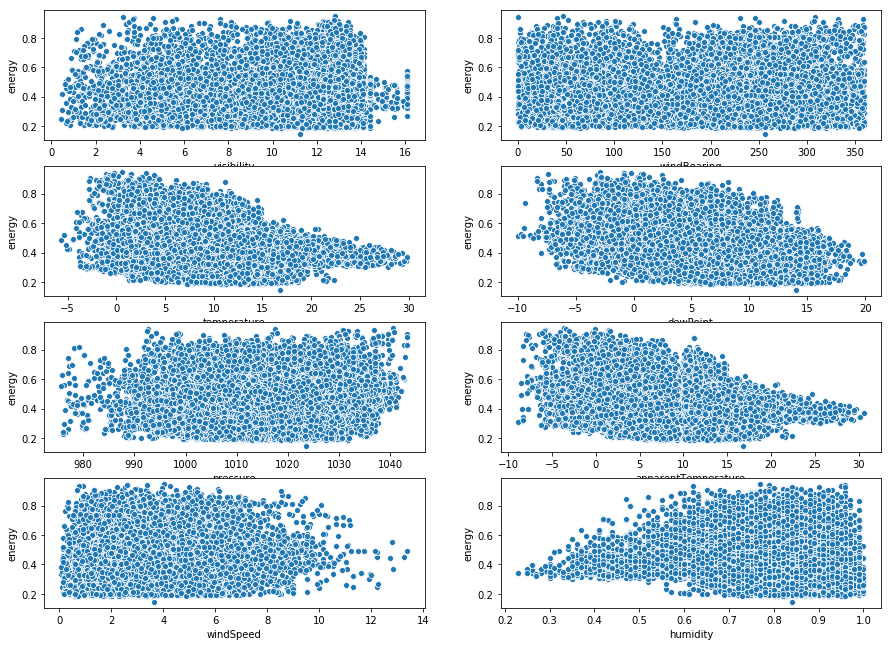

In [12]:
scatter_plot(train)

In [13]:
## deal with the only outliers in  energy data 
train.drop(train[(train["energy"] > 20)].index, inplace = True)
train.reset_index(drop=True, inplace=True)

### Calibration of distribution

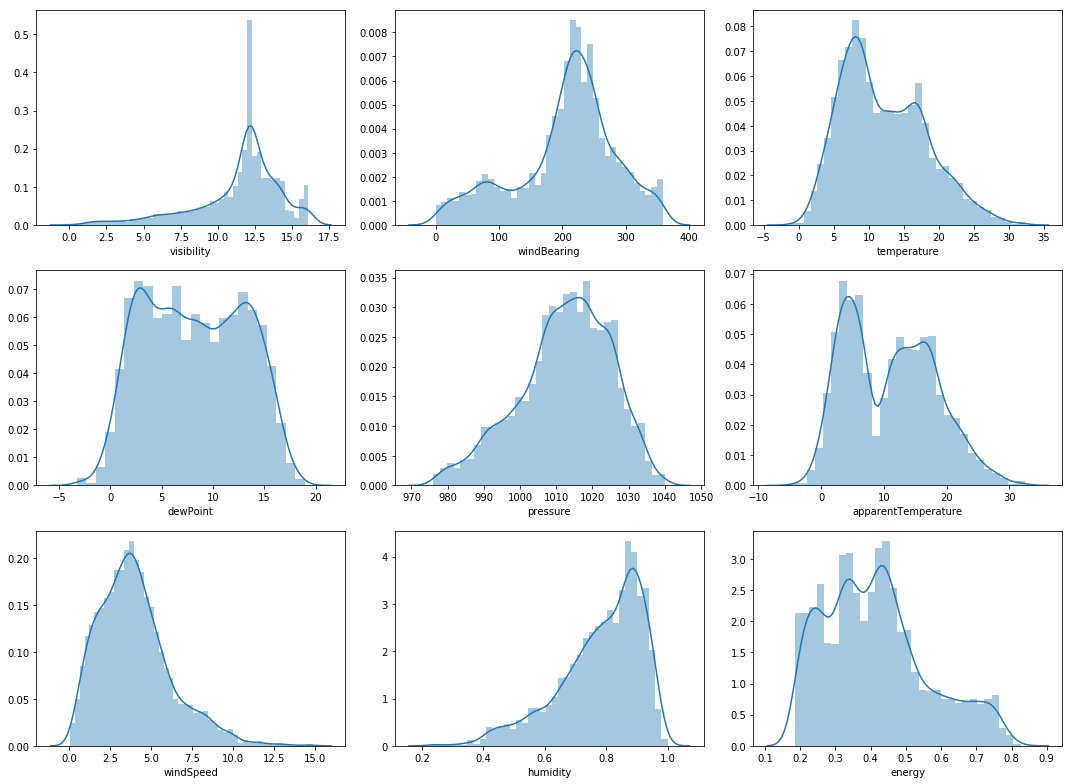

In [13]:
distri_plot(test)


We can observe that 
- left skew: **visibility**, **humidty** 
- right skew:  **windSpeed**, **temperature**
- weird shape: **windBearing**, **dewPoint**, **apparetTemp**

Apply transformation on them for more normal distribution

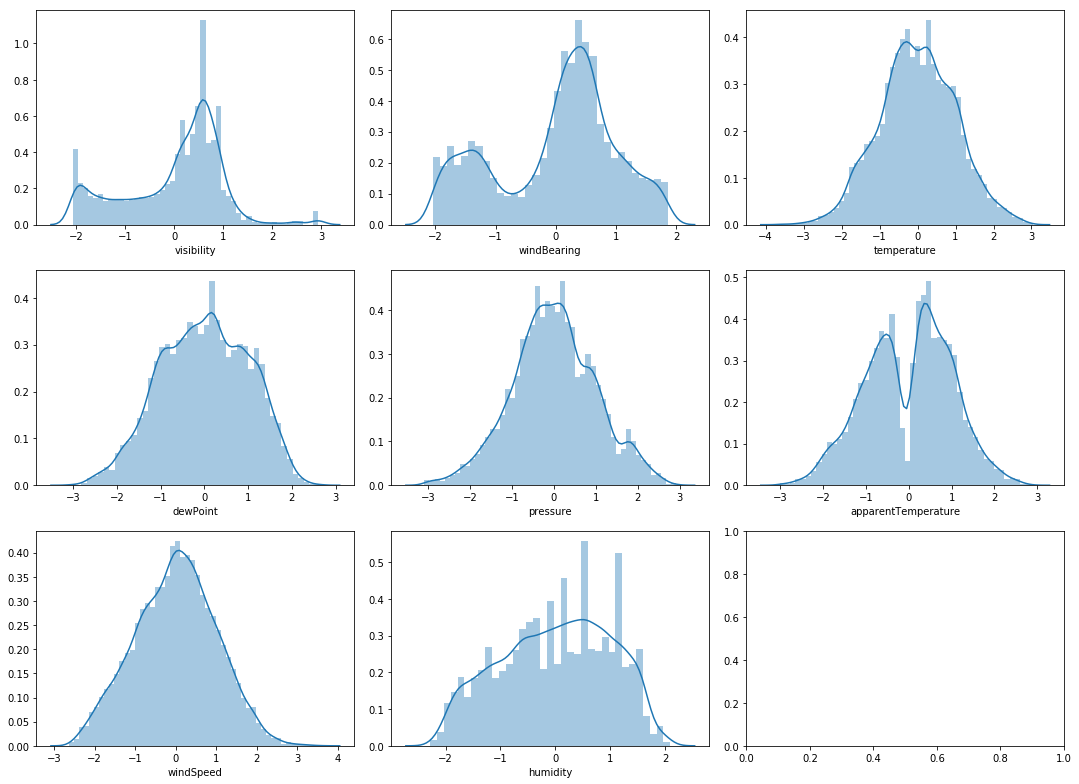

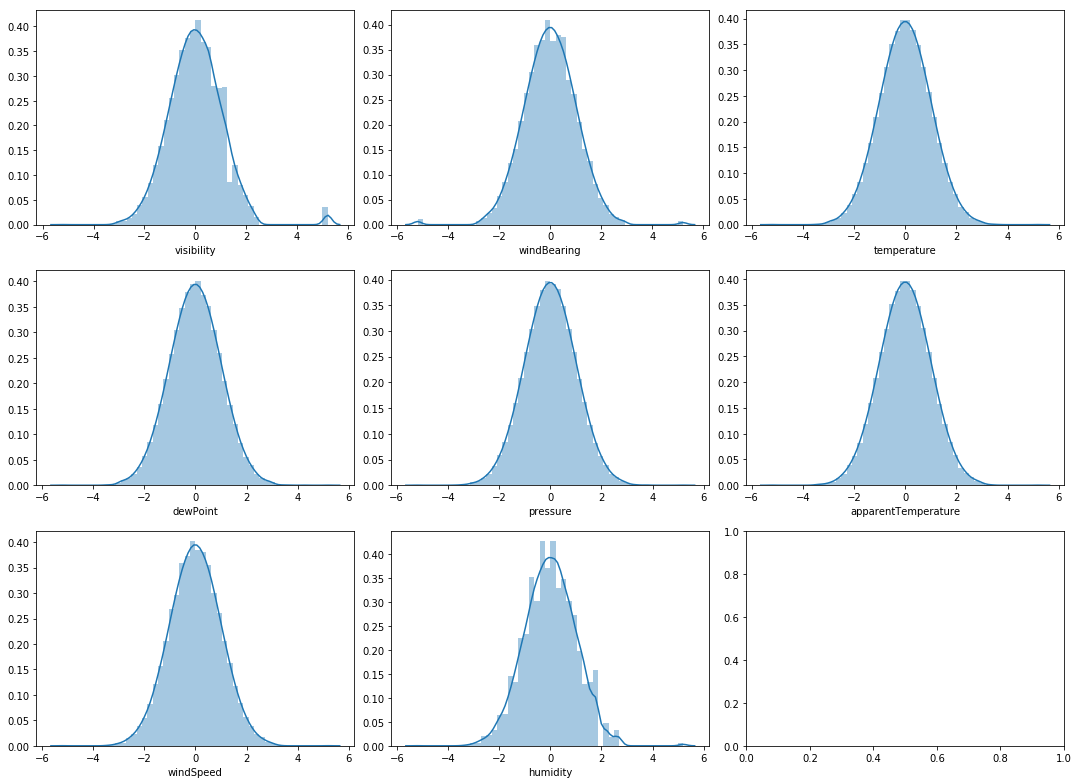

In [294]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
    
def power_trans(df):
    pt_boxc = PowerTransformer(method = "yeo-johnson")
    df_slice = df.iloc[:,:8]
    pt.fit(df_slice)
    df_trans = pd.DataFrame(pt.transform(df_slice), columns=['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'])
    return df_trans
train_trans = power_trans(train)

def quantile_trans(df):
    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
    df_slice = df.iloc[:,:8]
    qt.fit(df_slice)
    df_trans = pd.DataFrame(qt.transform(df_slice), columns=['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'])
    return df_trans

train_trans = power_trans(train)
train_quantile = quantile_trans(train)

##plot distribution
distri_plot(train_trans)
distri_plot(train_quantile)

### Creat lag ahead scenarios

In [34]:
#create 48 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)
single_w = train.iloc[:13991,:8]
#create 48 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_w.shape, ahead_e.shape, single_w.shape

((13991, 392), (13991, 49), (13991, 8))

### Scaling 

In [186]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(ahead_w)
st = mmscaler.transform(ahead_w)


In [72]:
from sklearn.preprocessing import MinMaxScaler

mmscaler_m = MinMaxScaler()
mmscaler_m.fit(multi_train)
mt = mmscaler_m.transform(multi_train)

### Feature Selection

In [188]:
# Tree based feature selection
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
reg = ExtraTreeRegressor(random_state=0).fit(st, ahead_e)
model = SelectFromModel(reg, prefit=True)
cols = model.get_support(indices=True)
mt_feature = model.transform(st)
cols ## the selected features column

array([ 98,  99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 134, 136, 139, 143, 146,
       245, 246, 247, 250, 252, 254, 258, 259, 261, 262, 263, 264, 266,
       269, 271, 272, 274, 280, 282, 288, 290, 326, 331, 344, 345, 347,
       350, 351, 354, 355, 356, 358, 359, 361, 364, 365, 369, 371, 377,
       379, 381, 383, 386, 388])

### TPOT

In [ ]:
from tpot import TPOTRegressor
from tpot_multi import mul_reg_config_dict
#import mul_config as mc## import multioutput regressor customized configuration
train_X = train.iloc[:1000,:30]
train_y = ahead.iloc[:1000,:]
tpot_reg = TPOTRegressor(generations=15, population_size=30, n_jobs=1, verbosity=2, random_state=1, config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X, train_y)


**Model generated by TPOT**

In [81]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
train_X, test_X, train_y, test_y = train_test_split(X_new, y_train_minmax, train_size = 0.7, test_size = 0.3)
# Average CV score on the training set was: -0.008001795169452104
rfr = RandomForestRegressor(bootstrap=False, max_features=0.4, min_samples_leaf=1, min_samples_split=3, n_estimators=100)
# Fix random state for all the steps in exported pipeline

rfr.fit(train_X, train_y)
yhat = rfr.predict(test_X)


In [82]:
yhat.shape, test_y.shape

((5941, 49), (5941, 49))

**Result evaluation**

In [83]:
import math
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.072


In [84]:
real = test_y
guess = yhat

real.shape, guess.shape

real = real[:1,:49]
guess = guess[:1,:49]

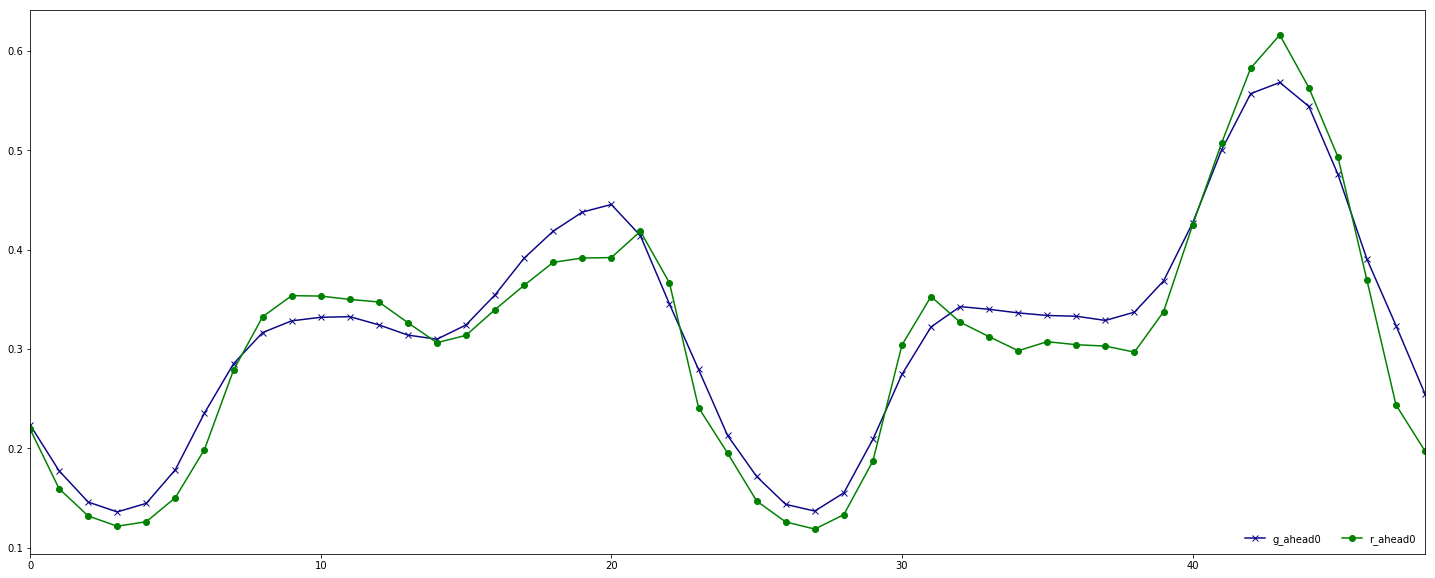

In [85]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()



### Random Forest Regression: Manual ML

In [190]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = mt_feature
y = ahead_e

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

#for i in range(50):
rfr = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
rfr.fit(train_X, train_y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [191]:
yhat = rfr.predict(val_X)

### Result evaluation: validation set

**Root Mean Square Error**

In [192]:
from sklearn.metrics import mean_squared_error
mean_squared_error(val_y, yhat)

0.004076983933704106

**Mean Absolute Error**

In [193]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, yhat)

0.048205666681675856

**R2 score**

In [194]:
from sklearn.metrics import r2_score
r2_score(val_y, yhat)

0.8273037570144528

**Visualization**

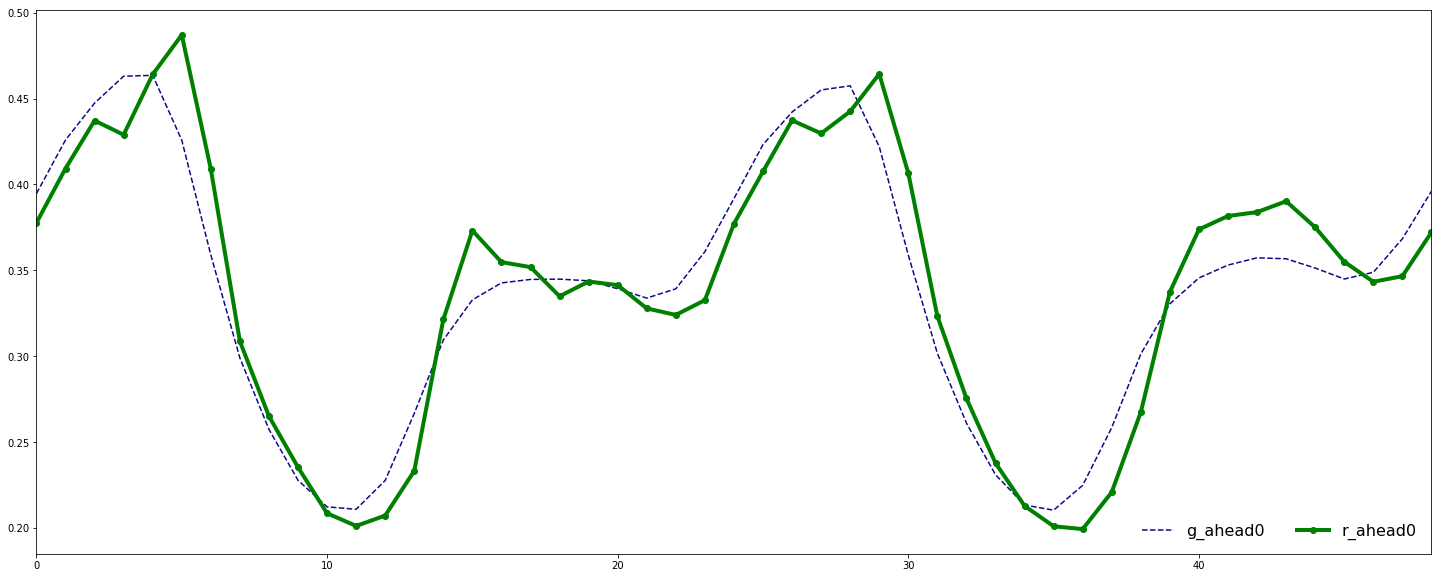

In [195]:
## assignment
real = val_y.to_numpy()
guess = yhat
real = real[:1,:49]
guess = guess[:1,:49]
rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Result evaluation: test set

**Data preparation for test set**

- prepare recency features
- feature scaling 
- identify feature picked from previous training process

In [196]:
## create 48 hours recency effect matrix
ahead_wt = lag_ahead_series(test.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)
#single_wt = train.iloc[:5775,:8]
#create 48 housrs ahead energy consumption matrix
ahead_et = lag_ahead_series(test.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_wt.shape, ahead_et.shape

((5775, 392), (5775, 49))

In [197]:
## feature scaling
#single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ahead_wt)

In [198]:
## feature pick up
test_x = mtest[:,cols]
test_y = ahead_et

In [199]:
## Prediction with test data
yt_hat = rfr.predict(test_x)

**Mean Square Error**

In [200]:
mean_squared_error(test_y, yt_hat)

0.006686032165989586

**Mean Absolute Error**

In [201]:
mean_absolute_error(test_y, yt_hat)

0.060261760079341156

**R2_score**

In [202]:
r2_score(test_y, yt_hat)

0.6894627184641356

**Visualization**

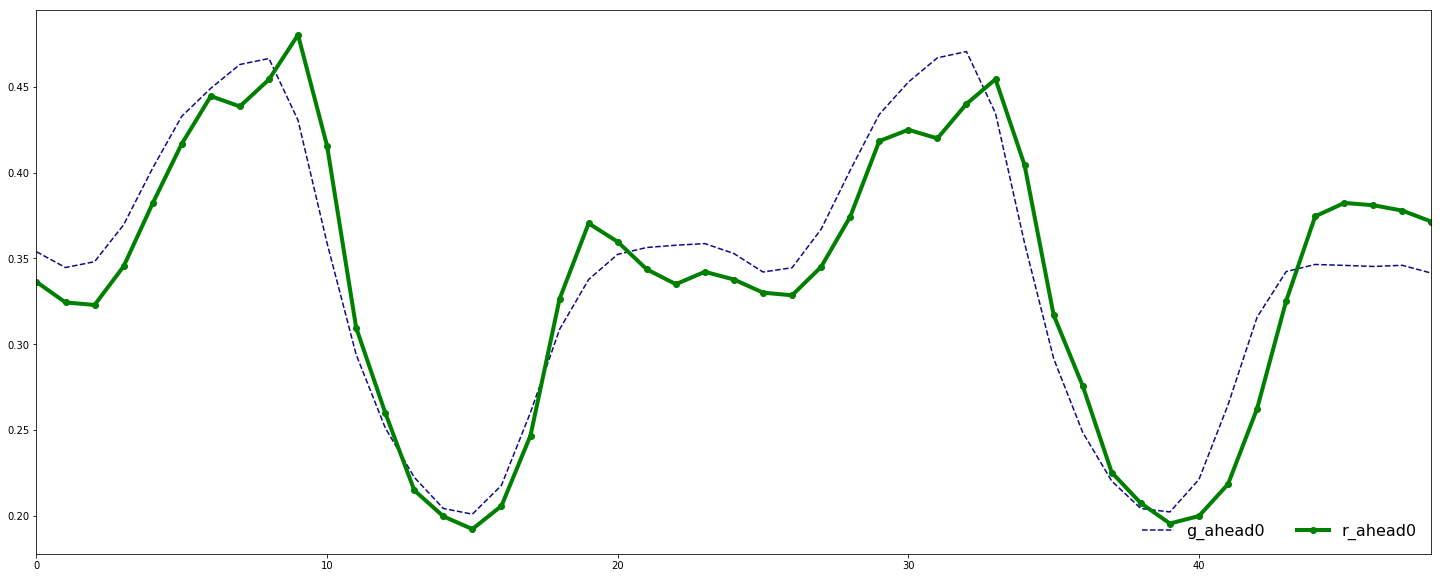

In [204]:
real = test_y.to_numpy()
guess = yt_hat
real = real[100:101,:49]
guess = guess[100:101,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             25800     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 49)             2499      
Total params: 28,299
Trainable params: 28,299
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 3s - loss: 0.1620
Epoch 2/50
 - 2s - loss: 0.1154
Epoch 3/50
 - 2s - loss: 0.1050
Epoch 4/50
 - 2s - loss: 0.0978
Epoch 5/50
 - 2s - loss: 0.0928
Epoch 6/50
 - 2s - loss: 0.0894
Epoch 7/50
 - 2s - loss: 0.0876
Epoch 8/50
 - 2s - loss: 0.0863
Epoch 9/50
 - 2s - loss: 0.0852
Epoch 10/50
 - 2s - loss: 0.0843
Epoch 11/50
 - 2s - loss: 0.0837
Epoch 12/50
 - 2s - loss: 0.0831
Epoch 13/50
 - 2s - loss: 0.0826
Epoch 14/50
 - 2s - loss: 0.0821
Epoch 15/50
 - 2s - loss: 0.0817
Epoch 16/50
 - 2s - loss: 0.0813
Epoch 17/50
 - 

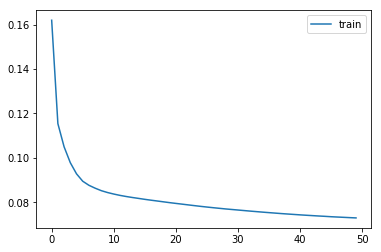

In [37]:
train_X, val_X, train_y, val_y = train_test_split(X_new, y_train_minmax, train_size = 0.9, test_size = 0.1)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.reshape((train_y.shape[0],1, train_y.shape[1]))

from keras.layers import TimeDistributed
# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(49)))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

**performace**


In [46]:
import math
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.098


In [43]:
#data preprocess
real = test_y
guess = yhat

real = real[:1,:]
guess = guess[:1,:]

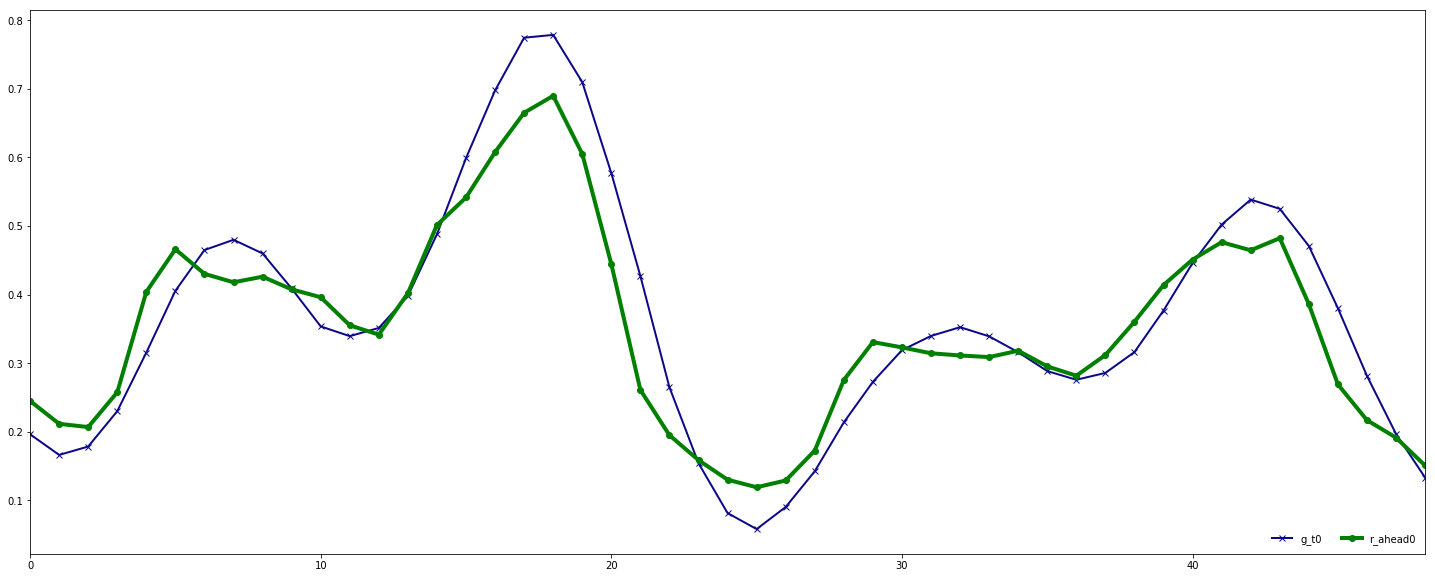

In [45]:
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

ax = plt.gca()

    
#plot 
gpdf.plot(figsize=(25,10),colormap='plasma',style='-x',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color='Green',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()